<a href="https://colab.research.google.com/github/omkarpat/EmpatheticDialoguesEmotionDetection/blob/master/Pos_Neg_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab settings/mount
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My\ Drive/CSE\ 245\ Project

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/CSE 245 Project


In [2]:
!pip install transformers

     |████████████████████████████████| 645kB 7.9MB/s 
     |████████████████████████████████| 890kB 22.9MB/s 
     |████████████████████████████████| 1.1MB 48.5MB/s 
     |████████████████████████████████| 3.8MB 58.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=a86e080b53e1b3023eda9e1bc8c036135ddf3df8923d0a854f3ccb7ced193494
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
!ls Data

'Data Exploration.ipynb'
 data_fixed_train.json
 data_sample_100.json
 data_sample_10.json
 data_sample_10_processed.json
 data_sample_fixed_processed_model1_final.csv
 data_sample_fixed_processed_model2_final.csv
 data_sample_fixed_processed_model3_final.csv
 data_sample_fixed_processed_model3_intermediate.csv
 data_sample_fixed_processed_model4_final.csv
 fixed
 fixed_test.json
 fixed_train_516.csv
 fixed_valid.json
'informative words.ipynb'
 Raw
 test_fixed_processed_model1_final.csv
 test_fixed_processed_model2_final.csv
 test_fixed_processed_model3_final.csv
 test_fixed_processed_model4_final.csv
 valid.csv
 valid_fixed_processed_model1_final.csv
 valid_fixed_processed_model2_final.csv
 valid_fixed_processed_model3_final.csv
 valid_fixed_processed_model4_final.csv


In [4]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [0]:
import pandas as pd
import numpy as np

In [0]:
train_df = pd.read_csv('Data/data_sample_fixed_processed_model1_final.csv', sep='|')
valid_df = pd.read_csv('Data/valid_fixed_processed_model1_final.csv', sep='|')
test_df = pd.read_csv('Data/test_fixed_processed_model1_final.csv', sep='|')

In [7]:
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))
print('Number of valid sentences: {:,}\n'.format(valid_df.shape[0]))
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))


# Display 10 random rows from the data.
train_df['label'] = train_df['processed_emotion'].apply(lambda x: 0 if x == "negative" else 1)
valid_df['label'] = valid_df['processed_emotion'].apply(lambda x: 0 if x == "negative" else 1)
test_df['label'] = test_df['processed_emotion'].apply(lambda x: 0 if x == "negative" else 1)
train_df.sample(10)

Number of training sentences: 19,533

Number of valid sentences: 2,763

Number of test sentences: 2,542



,emotion,processed_emotion,text,vader_neg,vader_neu,vader_pos,vader_compound,textblob,flair_value,flair_confidence,label
17101,nostalgic,positive,Might sell my home. It's the home I grew up in.,0.000,1.000,0.000,0.0000,0.000000,NEGATIVE,0.961691,1
1178,surprised,positive,just got out of work to my friend sending me a...,0.139,0.717,0.143,0.0258,-0.400000,NEGATIVE,0.936500,1
8764,grateful,positive,I am so happy that I have healthy_comma_ happy...,0.204,0.551,0.244,0.3199,0.275000,POSITIVE,0.896952,1
12148,furious,negative,My 15 year old son took my ferrari out for a t...,0.000,1.000,0.000,0.0000,0.241667,NEGATIVE,0.995662,0
2251,prepared,positive,i had worked with my pitchers all year. and it...,0.000,0.857,0.143,0.3612,0.200000,NEGATIVE,0.922604,1
9816,nostalgic,positive,My mom sent me a box of stuff from my childhood.,0.000,1.000,0.000,0.0000,0.000000,POSITIVE,0.879044,1
11611,afraid,negative,I am so scared of my dog dying.,0.347,0.653,0.000,-0.4927,0.000000,POSITIVE,0.859498,0
4162,joyful,positive,I get to go to Italy in a few months! I've bee...,0.000,1.000,0.000,0.0000,-0.250000,POSITIVE,0.999917,1
17004,guilty,negative,I felt bad when i noticed our dog went missing,0.487,0.513,0.000,-0.6908,-0.450000,POSITIVE,0.512273,0
7333,sad,negative,Kind of bummed. I was supposed to meet my best...,0.118,0.660,0.222,0.2960,0.800000,NEGATIVE,0.988691,0


In [0]:
sentences_train = train_df.text.values
labels_train = train_df.label.values
sentences_valid = valid_df.text.values
labels_valid = valid_df.label.values
sentences_test = test_df.text.values
labels_test = test_df.label.values

In [9]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [10]:
# Print the original sentence.
print(' Original: ', sentences_train[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences_train[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences_train[0])))

 Original:  I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.
Tokenized:  ['i', 'remember', 'going', 'to', 'the', 'fireworks', 'with', 'my', 'best', 'friend', '.', 'there', 'was', 'a', 'lot', 'of', 'people', '_', 'com', '##ma', '_', 'but', 'it', 'only', 'felt', 'like', 'us', 'in', 'the', 'world', '.']
Token IDs:  [1045, 3342, 2183, 2000, 1996, 16080, 2007, 2026, 2190, 2767, 1012, 2045, 2001, 1037, 2843, 1997, 2111, 1035, 4012, 2863, 1035, 2021, 2009, 2069, 2371, 2066, 2149, 1999, 1996, 2088, 1012]


In [11]:
max_len = 0
# For every sentence...
for sent in sentences_train:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max train sentence length: ', max_len)

max_len = 0
# For every sentence...
for sent in sentences_valid:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max valid sentence length: ', max_len)

max_len = 0
# For every sentence...
for sent in sentences_test:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max test sentence length: ', max_len)

Max train sentence length:  144
Max valid sentence length:  170
Max test sentence length:  139


In [0]:
def tokenize(sentences, labels):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 256,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.from_numpy(labels)

  # Print sentence 0, now as a list of IDs.
  print('Original: ', sentences[0])
  print('Token IDs:', input_ids[0])
  return(input_ids, attention_masks, labels)


In [17]:
input_ids_train, attention_masks_train, labels_train = tokenize(sentences_train, labels_train)
input_ids_valid, attention_masks_valid, labels_valid = tokenize(sentences_valid, labels_valid)
input_ids_test, attention_masks_test, labels_test = tokenize(sentences_test, labels_test)

Original:  I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.
Token IDs: tensor([  101,  1045,  3342,  2183,  2000,  1996, 16080,  2007,  2026,  2190,
         2767,  1012,  2045,  2001,  1037,  2843,  1997,  2111,  1035,  4012,
         2863,  1035,  2021,  2009,  2069,  2371,  2066,  2149,  1999,  1996,
         2088,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0, 

In [20]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_valid = TensorDataset(input_ids_valid, attention_masks_valid, labels_valid)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset_train))
val_size = len(dataset_train) - train_size

# Divide the dataset by randomly selecting samples.
#train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#Use the given training and validation datasets
train_dataset, val_dataset = dataset_train, dataset_valid

print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))

19,533 training samples
2,763 validation samples


In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [22]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 15

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [27]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 15 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  Batch    40  of    611.    Elapsed: 0:00:53.
  Batch    80  of    611.    Elapsed: 0:01:46.
  Batch   120  of    611.    Elapsed: 0:02:38.
  Batch   160  of    611.    Elapsed: 0:03:31.
  Batch   200  of    611.    Elapsed: 0:04:24.
  Batch   240  of    611.    Elapsed: 0:05:16.
  Batch   280  of    611.    Elapsed: 0:06:09.
  Batch   320  of    611.    Elapsed: 0:07:02.
  Batch   360  of    611.    Elapsed: 0:07:54.
  Batch   400  of    611.    Elapsed: 0:08:47.
  Batch   440  of    611.    Elapsed: 0:09:39.
  Batch   480  of    611.    Elapsed: 0:10:32.
  Batch   520  of    611.    Elapsed: 0:11:25.
  Batch   560  of    611.    Elapsed: 0:12:17.
  Batch   600  of    611.    Elapsed: 0:13:10.

  Average training loss: 0.30
  Training epcoh took: 0:13:24

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.26
  Validation took: 0:00:41

======== Epoch 2 / 15 ========
Training...
  Batch    40  of    611.    Elapsed: 0:00:53.
  Batch    80  of    611.    Elapsed: 0:01:45.
  Ba

In [28]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,2.97e-01,0.26,0.90,0:13:24,0:00:41
2,1.66e-01,0.30,0.90,0:13:23,0:00:41
3,1.03e-01,0.44,0.89,0:13:23,0:00:41
4,6.91e-02,0.46,0.90,0:13:23,0:00:41
5,4.96e-02,0.53,0.90,0:13:22,0:00:41
6,3.20e-02,0.64,0.90,0:13:22,0:00:41
7,2.55e-02,0.69,0.90,0:13:22,0:00:41
8,1.84e-02,0.74,0.90,0:13:23,0:00:41
9,1.11e-02,0.80,0.89,0:13:22,0:00:41


In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
train_df['flair_value'] = train_df['flair_value'].apply(lambda x: x.lower())
y_true = train_df.processed_emotion.values
y_pred = train_df.flair_value.values
#target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred))
print(accuracy_score(y_true, y_pred))

              precision    recall  f1-score   support

    negative       0.61      0.48      0.53      9673
    positive       0.58      0.70      0.63      9860

    accuracy                           0.59     19533
   macro avg       0.59      0.59      0.58     19533
weighted avg       0.59      0.59      0.58     19533

0.5870066042082629


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


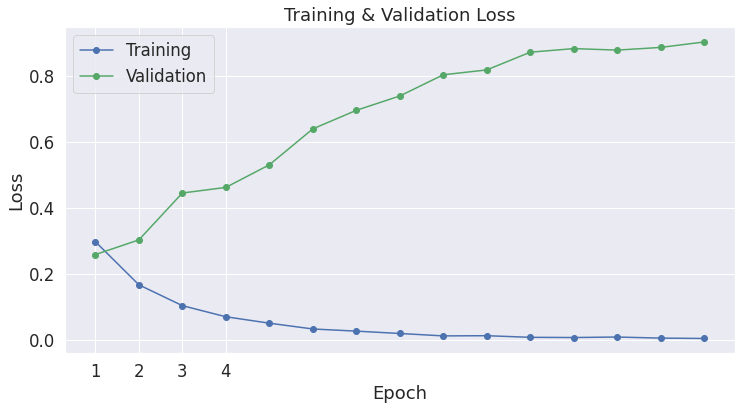

In [30]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [0]:
# Create the DataLoader for Test set.
prediction_data = dataset_test
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [33]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,542 test sentences...
    DONE.


In [45]:
for i in range(len(predictions)):
  if i == 0:
    pred_flat = np.argmax(predictions[i], axis=1).flatten()
    confidence_flat = np.amax(predictions[i], axis=1).flatten()
    labels_flat = true_labels[i].flatten()
    print(predictions[i])
    print(confidence_flat)
  else:
    pred_flat = np.append(pred_flat, np.argmax(predictions[i], axis=1).flatten())
    confidence_flat = np.append(confidence_flat, np.amax(predictions[i], axis=1).flatten())
    labels_flat = np.append(labels_flat, true_labels[i].flatten())

print(len(pred_flat), len(labels_flat))
print(classification_report(labels_flat, pred_flat))
print(accuracy_score(labels_flat, pred_flat))

[[ 5.5857515 -5.725335 ]
 [ 5.47231   -5.614704 ]
 [-5.6369643  5.8508744]
 [-5.5859647  5.8626122]
 [-5.5830846  5.7249947]
 [ 5.3411417 -5.341119 ]
 [ 5.4974604 -5.529719 ]
 [ 5.313862  -5.511909 ]
 [-5.690269   5.914673 ]
 [-5.337232   5.673433 ]
 [ 4.8303328 -5.365035 ]
 [ 5.098995  -5.5122976]
 [-5.3504124  5.635365 ]
 [-5.451075   5.705458 ]
 [-5.7685485  5.906415 ]
 [-5.6659765  5.8498726]
 [-5.700473   5.9068937]
 [ 5.4459395 -5.6214213]
 [ 5.156014  -5.1797037]
 [ 5.045055  -5.3748627]
 [-1.3112459  1.9447333]
 [-5.699914   5.921694 ]
 [-5.0996814  5.3286257]
 [ 5.4432073 -5.571834 ]
 [ 5.468812  -5.6143928]
 [-5.6639633  5.797509 ]
 [ 4.339024  -4.781442 ]
 [ 4.7862616 -4.850921 ]
 [-4.5241494  4.88408  ]
 [-4.2875347  4.6351185]
 [-5.7013     5.8761296]
 [ 5.502531  -5.562279 ]]
[5.5857515 5.47231   5.8508744 5.8626122 5.7249947 5.3411417 5.4974604
 5.313862  5.914673  5.673433  4.8303328 5.098995  5.635365  5.705458
 5.906415  5.8498726 5.9068937 5.4459395 5.156014  5.04505

In [44]:
print('Positive samples in train: %d of %d (%.2f%%)' % (train_df.label.sum(), len(train_df.label), (train_df.label.sum() / len(train_df.label) * 100.0)))
print('Positive samples in valid: %d of %d (%.2f%%)' % (valid_df.label.sum(), len(valid_df.label), (valid_df.label.sum() / len(valid_df.label) * 100.0)))
print('Positive samples in test: %d of %d (%.2f%%)' % (test_df.label.sum(), len(test_df.label), (test_df.label.sum() / len(test_df.label) * 100.0)))

Positive samples in train: 9860 of 19533 (50.48%)
Positive samples in valid: 1386 of 2763 (50.16%)
Positive samples in test: 1315 of 2542 (51.73%)
